In [45]:
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import RYGate
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer import *
from qiskit.quantum_info import *

qiskit.__qiskit_version__

{'qiskit-terra': '0.13.0',
 'qiskit-aer': '0.4.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.6',
 'qiskit': '0.18.0'}

In [46]:
def g_(sigma_, mu_, lim):
    # normalization function, equal to psi tilde squared, summed over all the integers.
    # in lieu of an infinite sum, we can simply make ``lim" sufficiently high. 
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1) - mu_)**2)/float((2)*sigma_**2)))

def angle_(sigma_, mu_, lim=10**3):
    # Calculates the angle, based on the square root of probability. 
    # cutoff the infinite sum in g_(...) at 10**3 by default
    return np.arccos(np.sqrt(g_(sigma_/2., mu_/2., lim)/g_(sigma_, mu_, lim)))

def ctrl_states(n):
    states = []
    for i in range(0,2**n):
        s = bin(i).replace("0b", "")
        states.append("".join(["0" for j in range(0,n-len(s))])+s)
    return states


ctrl_states(3)

['000', '001', '010', '011', '100', '101', '110', '111']

In [47]:
def new_mu(qub, mu):
    # calculate modified \mu for n-bit string qubit
    # i.e., we have g(b, mu) = (mu - b)/2, b \in {0,1}, and g('',mu) = mu
    # e.g., h('101101', mu) = g('1',g('0',g('1',g(...)))) etc.
    new_mean = mu
    for bit in qub[::-1]:#reversed because we consider the qubits increasingly further back
        new_mean = (new_mean/2.) - ((1/2.)*int(bit))
    return new_mean

In [48]:
def create_circ(N, mu_, sig_,):
    qr = QuantumRegister(N, 'q')
    qc = QuantumCircuit(qr)# Generate a quantum circuit with a quantum register (list) of qubit objects
    alpha_0 = angle_(sig_, mu_) # We multiply by 2, because the ry gate rotates by alpha/2
    qc.ry(2*alpha_0,0) # apply a rotation angle of alpha_0 (multiply by 2 because gate halves parameter)
    for i in range(1,N): # Steps to be done at level q_i
        qstring = ctrl_states(i) # create list of 2^i strings of length i
        for k in qstring:
            alpha_ = angle_(sig_/(2**i), new_mu(k, mu_)) # Calculate angle using modified mean
            new_gate = RYGate(2*alpha_).control(num_ctrl_qubits = i, 
                                                label = None, 
                                                ctrl_state=k) # control state is 
            qc.append(new_gate, qr[:i+1]) # add ry gate to level

    return qc


[0.04060297+0.j 0.05518043+0.j 0.09138467+0.j 0.14353515+0.j
 0.20804396+0.j 0.27770399+0.j 0.34133136+0.j 0.38630723+0.j
 0.40257956+0.j 0.38630723+0.j 0.34133136+0.j 0.27770399+0.j
 0.20804396+0.j 0.14353515+0.j 0.09138467+0.j 0.05518043+0.j]
sum: (1.000000000000003+0j)


C:\Users\andre\Anaconda3\envs\shlab\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


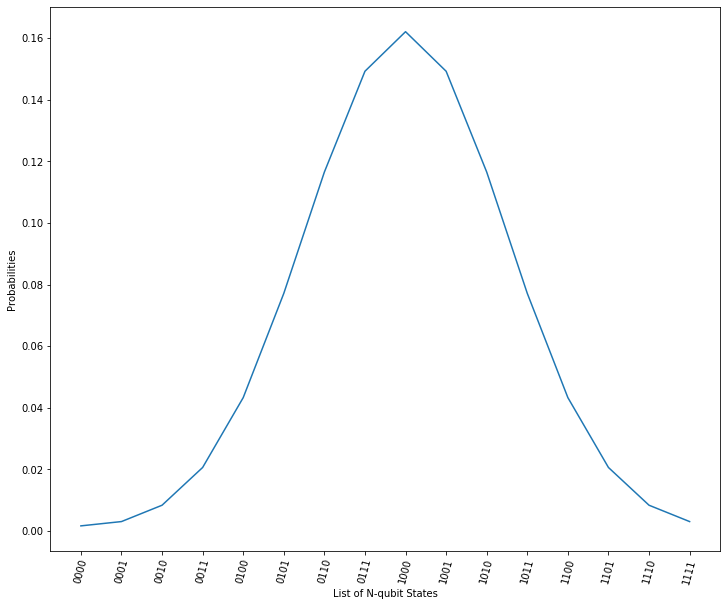

In [82]:
N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)


backend = Aer.get_backend('statevector_simulator')
state = execute(qc, backend).result().get_statevector()

print(state)

probs = [x*x for x in state]

print('sum: ' + str(sum(probs)))

# plot the probabilities

ctrls = ctrl_states(N)
plt.figure(figsize=(12, 10))
plt.plot(range(len(ctrls)), probs)
plt.xticks(range(len(ctrls)), ctrls, rotation=75)
#plt.bar(wavefcn_xlist, wavefcn_ylist)
plt.xlabel('List of N-qubit States')
plt.ylabel('Probabilities')
plt.show()

In [83]:
s = Statevector(state)

s.dim

16

In [84]:
b = s.sample_counts(4096)
print(b)

{'0000': 9, '0001': 11, '0010': 34, '0011': 79, '0100': 173, '0101': 313, '0110': 455, '0111': 611, '1000': 676, '1001': 625, '1010': 492, '1011': 318, '1100': 179, '1101': 79, '1110': 26, '1111': 16}


<Figure size 432x288 with 0 Axes>

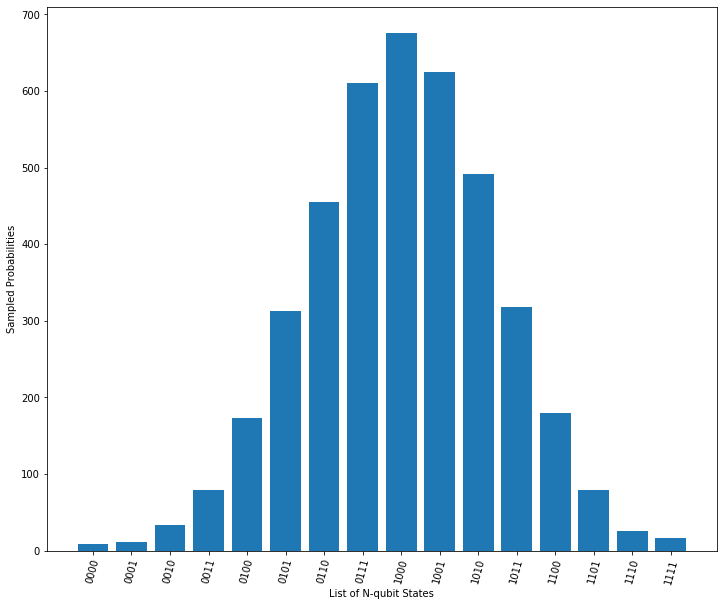

In [85]:
plt.clf()


plt.figure(figsize=(12, 10))
#plt.plot(range(len(b.keys()), b.values())
#plt.xticks(range(len(b.keys())), b.keys(), rotation=75)
plt.xticks(rotation=75)
plt.bar(b.keys(), b.values())
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()